In [1]:
import sys
import os
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np

sys.setrecursionlimit(10**6)

In [56]:
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

In [2]:
def merge_ch(image):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(image, axis=2)
    return image

In [3]:
def threshold(image, val=0.0, reverse=False):
    h, w = image.shape

    if reverse:
        background = image[:, :] > val
    else:
        background = image[:, :] < val
        
    image[~background] = 255
    image[background] = 0

    return image

In [8]:
def get_neighbours(k):
    neighbours = [
        [1, 0],
        [0, 1],
        [-1, 0],
        [0, -1],
    ]
    if k == 8:
        diag_neighbours = [
            [-1, -1],
            [1, 1],
            [-1, 1],
            [1, -1]
        ]
        neighbours += diag_neighbours

    return neighbours

def connected_components(arr, p, components, h, foreground, n_dir=8):
    arr = arr.copy()
    height, width = len(arr), len(arr[0])
    visited = set()
    
    def dfs(i, j, p):
        nonlocal height, width, arr, visited, components
        if i < 0 or i >= height or j < 0 or j >= width or arr[i][j] == -1 or (i, j) in visited:
            return
       
        visited.add((i, j))
        arr[i][j] = p
        components[p]['left'] = min(components[p].get('left', float('inf')), i+h)
        components[p]['right'] = max(components[p].get('right', float('-inf')), i+h)
        components[p]['top'] = min(components[p].get('top', float('inf')), j)
        components[p]['bottom'] = max(components[p].get('bottom', float('-inf')), j)
        neighbour_idx = get_neighbours(n_dir)
        
        for x, y in neighbour_idx:
            dfs(i+x, j+y, p)
    
    for j in range(width):
        for i in range(height):
            if arr[i][j] == foreground and (i, j) not in visited:
                dfs(i, j, p)
                p += 1
                
    return p

In [9]:
def get_component(components, idx, img, show=False):
    component = components[idx]
    left, right = component['left'], component['right']
    top, bottom = component['top'], component['bottom']
    image = img[left:right+1, top:bottom+1]
    if show:
        _ = plt.imshow(image, cmap='gray')
    
    return (left, top, right-left+1, bottom-top+1), image

In [10]:
def gaussian_kernel(size, sigma):
    kernel_1d = np.linspace(- (size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(kernel_1d) / np.square(sigma))
    kernel_2d = np.outer(gauss, gauss)
    return kernel_2d / np.sum(kernel_2d)

In [11]:
def convolve(image, kernel, stride, padding=0):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    h = ((img_h - k_h + (2 * padding)) // stride) + 1
    w = ((img_w - k_w + (2 * padding)) // stride) + 1

    kernel = np.flipud(np.fliplr(kernel))
    output = []
    image = np.pad(image, pad_width=padding)

    for i in range(0, img_h-k_h+1, stride):
        for j in range(0, img_w-k_w+1, stride):
            region = image[i:i+k_h, j:j+k_w]
            output.append(np.multiply(region, kernel).sum())

    output = np.asarray(output).reshape(h, w)
    return output

In [12]:
def gaussian_pyramid(image, n, kernel_len=5, sigma=1):
    image = image.copy()
    res = []
    for i in range(n):
        image = convolve(
            image=image,
            kernel=gaussian_kernel(
                size=kernel_len,
                sigma=sigma,
            ),
            stride=2,
        )
        res.append(image)

    return res

In [13]:
def expand(image, factor=2):
    "Nearest neighbour interpolation"
    img_h, img_w = image.shape
    h, w = img_h * factor, img_w * factor
    output = []

    for i in range(img_h):
        for j in range(img_w):
            for _ in range(factor):
                output.append(image[i][j])
        for _ in range(factor-1):
            output += output[-img_w*factor:]

    output = np.asarray(output).reshape(h, w)
    return output

In [14]:
def extract_features(image, detector):
    keypoints, desc = detector.detectAndCompute(image, None)
    return keypoints, desc

In [15]:
def sim_cosine(a, b):
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim

In [16]:
def norm_l2(a, b):
    return np.linalg.norm(np.asarray(a)-np.asarray(b))

In [17]:
class Matcher:
    def __init__(self, s_idx, t_idx, score):
        self.s_idx = s_idx
        self.t_idx = t_idx
        self.score = score

In [18]:
def matcher(s_desc, t_desc, measure, reverse=False):
    arr = []
    
    for s_idx, s_d in enumerate(s_desc):
        min_score = float('inf')
        min_idx = 0
        for t_idx, t_d in enumerate(t_desc):
            score = measure(s_d, t_d)
            if score < min_score:
                min_score = score
                min_idx = t_idx
                
        arr.append(Matcher(s_idx, min_idx, round(min_score, 2)))
        
    return sorted(arr, reverse=reverse, key=lambda x: x.score)

In [19]:
def g_noise(image, var=0.5):
    row, col = image.shape
    mean = 0
    var = var
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma, (row, col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy.astype(np.uint8)

In [21]:
def matcher(s_desc, t_desc, measure, reverse=False):
    arr = []

    for s_idx, s_d in enumerate(s_desc):
        min_score = float('inf')
        for t_idx, t_d in enumerate(t_desc):
            score = measure(s_d, t_d)
            if score < min_score:
                min_score = score

        arr.append(round(min_score, 2))

    return sorted(arr, reverse=reverse)

# _, dsc_t = extract_features(dot_p, sift)
# _, dsc_tt = extract_features(e, sift)
# dist = matcher(dsc_t, dsc_tt, norm_l2)
# sum(dist)/len(dist)

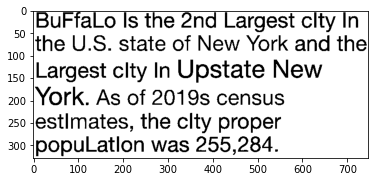

In [22]:
# apply Sauvola local adaptive thresholding
img = cv2.imread('data/test_img.jpg', cv2.IMREAD_GRAYSCALE)
bin_img = threshold(img, 100)
_ = plt.imshow(bin_img, cmap='gray')

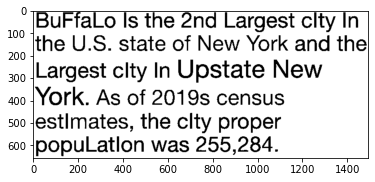

In [35]:
# apply Sauvola local adaptive thresholding
img = cv2.imread('data/test_img.jpg', cv2.IMREAD_GRAYSCALE)
img = expand(img, 2)
bin_img = threshold(img, 100)
_ = plt.imshow(bin_img, cmap='gray')

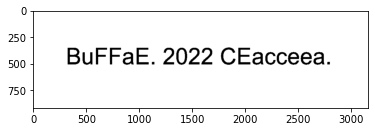

In [87]:
# apply Sauvola local adaptive thresholding
img = cv2.imread('data/test2.png', cv2.IMREAD_GRAYSCALE)
img = expand(img, 3)
bin_img = threshold(img, 100)
_ = plt.imshow(bin_img, cmap='gray')

In [88]:
# bin_img = expand(bin_img, 2)
res = []
k = 0
components = defaultdict(dict)
flag = True
p = 0
h, w = bin_img.shape
bimg = bin_img.copy().astype(np.int16)

for i in range(h):
    temp = (bimg[i, :] == 0.).any()
    if temp == flag:
        if flag:
            res.append([i])
        else:
            res[-1].append(i)
        flag = not flag
        
for i in range(h):
    for j in range(w):
        if bimg[i][j] == 255:
            bimg[i][j] = -1
        
for h1, h2 in res:
    p = connected_components(
        bimg[h1:h2+1, :],
        p,
        components,
        h1,
        foreground=0,
    )

In [89]:
len(components.keys())

20

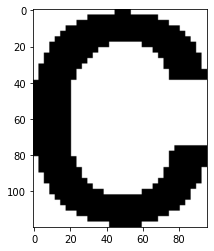

In [90]:
_, test_img = get_component(components, 14, bin_img, show=True)

In [91]:
_, test = extract_features(np.pad(test_img, 3), sift)
_, actual = extract_features(np.pad(a, 2), sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist)

[372.02, 406.79, 406.92, 407.5, 410.78, 412.94, 418.44, 418.8, 420.51, 423.04, 436.16, 438.58, 454.73, 460.07, 471.89, 476.52, 476.71, 477.15, 478.43, 479.0, 480.64, 481.51, 505.48]


444.11348027768344

In [92]:
_, test = extract_features(np.pad(test_img, 3), sift)
_, actual = extract_features(np.pad(e, 2), sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist)

[353.82, 359.76, 361.7, 368.7, 369.24, 382.87, 383.05, 388.21, 391.24, 394.6, 403.19, 404.79, 404.81, 409.27, 419.99, 437.09, 439.85, 448.46, 460.73, 483.07, 487.86, 495.52, 497.0]


414.99217290463656

In [93]:
_, test = extract_features(np.pad(test_img, 3), sift)
_, actual = extract_features(np.pad(c, 2), sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist)

[207.15, 219.82, 264.81, 327.85, 368.4, 378.83, 379.88, 384.75, 385.15, 396.01, 405.99, 407.18, 433.91, 461.35, 494.74, 494.99, 496.82, 498.54, 500.47, 505.32, 513.02, 514.18, 523.75]


415.77869581139606

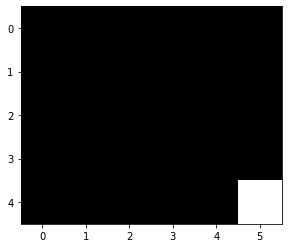

In [418]:
_, img_i = get_component(components, 141, img, True)

In [303]:
bordersize = 1
border = cv2.copyMakeBorder(
    sq,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0]
)

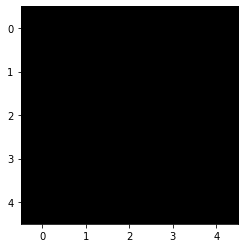

In [309]:
_ = plt.imshow(img_i, cmap='gray')

In [393]:
from scipy import ndimage

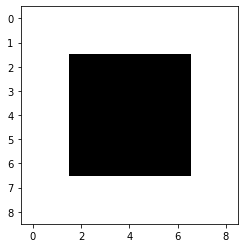

In [356]:
sq = np.pad(img_i, 2, constant_values=255.)
_ = plt.imshow(sq, cmap='gray')

In [412]:
sq_up = expand(sq, 2)

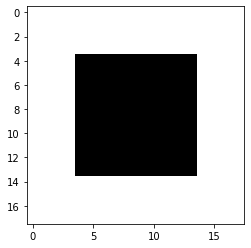

In [413]:
_ = plt.imshow(sq_up, cmap='gray')

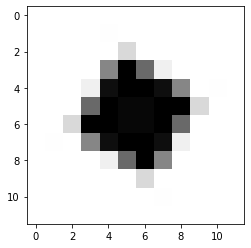

In [399]:
#rotation angle in degree
rotated = ndimage.rotate(sq, 60, cval=255.)
_ = plt.imshow(rotated, cmap='gray')

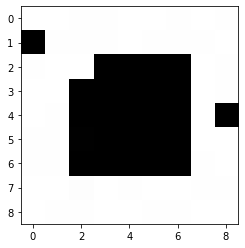

In [392]:
_ = plt.imshow(g_noise(sq, 0.3), cmap='gray')

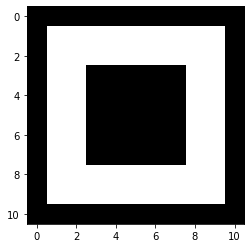

In [337]:
sq = np.pad(img_i, 2, constant_values=255.)
_ = plt.imshow(border, cmap='gray')

In [57]:
class Recognition:
    def __init__(self, matcher, measure=None, n=50):
        self.matcher = matcher
        self.bf = cv2.BFMatcher()
        self.n = n
        
    def match(self, img1, img2):
        score = 0
        kp_1, dsc_1 = self.matcher.detectAndCompute(img1, None)
        kp_2, dsc_2 = self.matcher.detectAndCompute(img2, None)
        
        matches = self.bf.match(dsc_1, dsc_2)
        matches = sorted(matches, key = lambda x:x.distance)
        
        print([match.distance for match in matches])

        if matches:
            dist = sum([match.distance for match in matches[:self.n+1]])
            if dist == 0:
                score = 100
            else:
                score = (min(self.n+1, len(matches))/dist) * 100
        img = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:self.n+1], None, flags=2)
        
        return matches, score, img

recog_sift = Recognition(sift, n=50)
recog_orb = Recognition(orb, n=10)

In [51]:
a = cv2.imread('data/characters/a.jpg', cv2.IMREAD_GRAYSCALE)
# _ = plt.imshow(a, cmap='gray')

dot = cv2.imread('data/characters/dot.jpg', cv2.IMREAD_GRAYSCALE)
# _ = plt.imshow(dot, cmap='gray')

c = cv2.imread('data/characters/c.jpg', cv2.IMREAD_GRAYSCALE)
# _ = plt.imshow(c, cmap='gray')

e = cv2.imread('data/characters/e.jpg', cv2.IMREAD_GRAYSCALE)
# _ = plt.imshow(e, cmap='gray')

two = cv2.imread('data/characters/2.jpg', cv2.IMREAD_GRAYSCALE)
# _ = plt.imshow(two, cmap='gray')

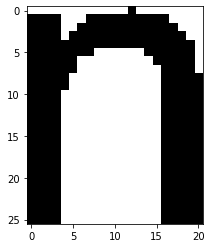

In [217]:
a_t = get_component(components, 17, img, show=True)
o_t = get_component(components, 22, img, show=True)
e_t = get_component(components, 23, img, show=True)
c_t = get_component(components, 27, img, show=True)

[227.36314392089844, 231.72181701660156, 258.3621520996094, 297.1531677246094, 330.35888671875, 333.274658203125, 342.9227294921875, 392.6652526855469, 398.58624267578125, 428.3865051269531, 435.6133728027344, 444.99212646484375, 470.6102294921875, 484.9670104980469]
0.2757546308903758


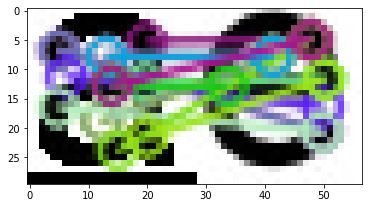

In [59]:
_, score, im = recog_sift.match(a, e)
print(score)
_ = plt.imshow(im, cmap='gray')

[0.0, 0.0, 0.0, 0.0]
100


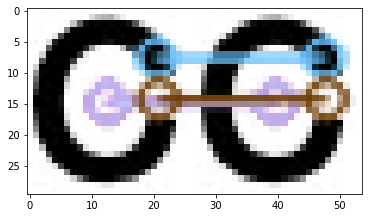

In [60]:
_, score, im = recog_sift.match(c, c)
print(score)
_ = plt.imshow(im, cmap='gray')

In [232]:
import json

In [183]:
with open('data/groundtruth.json') as f:
    x = eval(f.read())

In [196]:
def test(k):
    y, x, h, w = k
    plt.imshow(bin_img[x:x+w, y:y+h], cmap='gray')

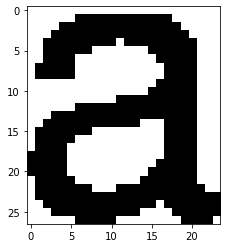

In [197]:
test(x[14]['bbox'])